<a href="https://colab.research.google.com/github/threewisemonkeys-as/causal-meta-rl/blob/main/Causal_Meta_RL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Causal Reasoning from Meta-Reinforcement Learning

Exploration of how Causal Reasoning can arise in Meta RL based on *Dasgupta et. al.* [Causal Reasoning from Meta-Reinforcement Learning](https://arxiv.org/abs/1901.08162)

Results from all experiments can be found at: https://wandb.ai/atharv/causal-meta-rl

# Setup

Installing and importing required packages. Seeding random number generators for reproducability

In [ ]:
#@title
!pip install -qqq wandb
%load_ext tensorboard

In [ ]:
#@title
from datetime import datetime
import itertools
from dataclasses import dataclass
from typing import List
from pathlib import Path
import random
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import gym

import torch
import torch.nn as nn
import torch.nn.functional as F

import wandb

In [ ]:
#@title
seed = 42

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# What is Causal Reasoning?









When looking at relationships between varirables, we know that *correlation* does not imply *causation*. While most Machine Learning methods only model correlations, humans routinely make use of causal relationships to make useful inferences.


Thus the ability to do Causal Reasoning maybe be an important characteristic of an inteligent system.


Consider the following example. Using a statistical or machine learning method, we can easily discover a correlation between the number of launches and number of sociology graduates. Does this mean that one causes the other? 


Usually in such a case there is/are confounding variable(s) which are unobserved but may cause both of these phenomenon. 



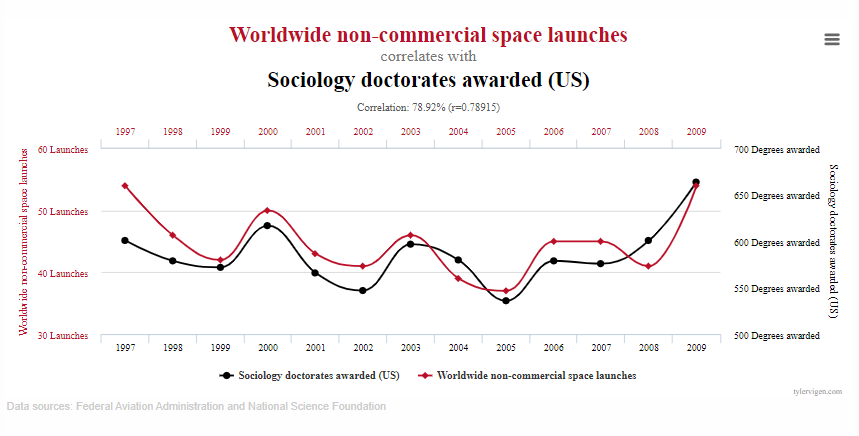

# Causal Graphical Models


Causal relationships between variables can be represented as a Directed Acyclic Graph (DAG). In the following experiments, we assume that all our variables follow a Gaussian Distribution with a fixed variance (0.1) and means being a weighted sum of the parents - 

$\mathcal{N}(\mu = \Sigma_j w_{ij} X_j, \sigma = 0.1)$ where $X_j \in \text{pa}(X_i)$


Root nodes (without parents) have fixed means (0) - $\mathcal{N}(\mu = 0, \sigma = 0.1)$

The following shows an examples of DAGs representing a causal models.

The important thing to not is the difference between the two. The right model is the left model but with an intervention on `E`. For this we can see than iterventions (setting the value of a variable manually as opposed to conditioning on them) cause the underlying probabilistic model itself to change. 

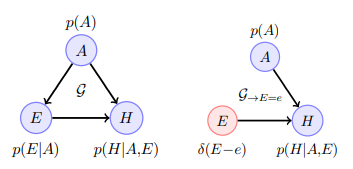

## Dataset Generation

The dataset of graphical models on which the RL agent is trained consists of all possible DAGs of some fixed size which edge weights being either 1 or -1. To save on repeated comutation, the dataset has been pre prepared and is available to download. It can be created from scratch also by uncommenting the requisite lines in the following cells

In [ ]:
# download pre made dataset. This can be created from scratch in the cell below

!wget -q http://threewisemonkeys-as.github.io/files/causal-meta-rl/graphs_dataset.pkl
!wget -q http://threewisemonkeys-as.github.io/files/causal-meta-rl/eq_classes.pkl

Number of total graphs: 59049
Number of equivalence classes of graphs: 302
Visualisation -


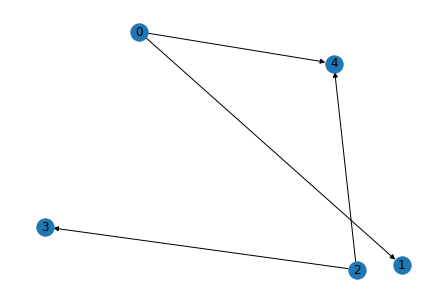

In [ ]:
def generate_data(N=5):
    """ Generate all possible DAGs of N nodes with edge weights being either 1 or -1 """

    r = []
    for k in itertools.combinations_with_replacement([-1, 0, 1], (N*(N-1))//2):
        for m in set(itertools.permutations(k)):
            A = np.zeros((N, N))
            A[np.triu_indices(N, 1)] = m
            r.append(nx.from_numpy_matrix(A, create_using=nx.DiGraph))
    return r


def generate_data_randomly(N, num_samples):
    """ Generates a specified number of DAGs of specified size by random sampling 
        Useful when generating data DAGS with size > 6
    """

    data = []
    i = 0
    while True:
        new = True
        g = np.random.choice([-1, 0, 1], (N*(N-1))//2)
        for d in data:
            if np.array_equal(g, d):
                new = False
                break
        if new:
            data.append(g)
            i += 1

        if i >= num_samples:
            break
    
    generated = []
    for d in data:
        g = np.zeros((N, N))
        g[np.triu_indices(N, 1)] = d
        generated.append(nx.from_numpy_matrix(g, create_using=nx.DiGraph))

    return generated


def partition(data):
    """ Paritions list of DAGs into list of equivalence clases where each DAG is 
        isomorphic to the other DAGs in the equivalence class
    """

    equiv_classes = []
    for g in data:
        found = False
        for i, c in enumerate(equiv_classes):
            if nx.is_isomorphic(g, c[0]):
                equiv_classes[i].append(g)
                found = True
                break
        if not found:
            equiv_classes.append([g])
    return equiv_classes


## uncomment to generate data from scratch (may take a few minutes) -
# data = generate_data(5)
# eq_classes = partition(data)
# pickle.dump(data, open("graphs.pkl", "wb"))
# pickle.dump(eq_classes, open("eq_classes.pkl", "wb"))


# load data
data = pickle.load(open("graphs_dataset.pkl", "rb"))
eq_classes = pickle.load(open("eq_classes.pkl", "rb"))

print(f"Number of total graphs: {len(data)}")
print(f"Number of equivalence classes of graphs: {len(eq_classes)}")

g = data[42000]
print("Visualisation -")
nx.draw(g, with_labels=True)

## Train / Test Split

The dataset (set of equivalence classes) is split randomly into a train and test set. The RL agent is trained on the train set and evaluated on the test set to ensure that it does not just memorise graphs

In [ ]:
def split_train_test(eq_classes, n_test):
    """ Splits list of equivalence classes into train and test randomly """

    assert n_test <= len(eq_classes), "n_test must be less than or equal to number of data points"
    test_idx = random.sample(range(len(eq_classes)), k=n_test)
    test_c = [eq_classes[i] for i in range(len(eq_classes)) if i in test_idx]
    train_c = [eq_classes[i] for i in range(len(eq_classes)) if i not in test_idx]
    return [i for c in train_c for i in c], [i for c in test_c for i in c]

train_g, test_g = split_train_test(eq_classes, 12)
print(f"Train: {len(train_g)} | Test: {len(test_g)}")

Train: 55673 | Test: 3376


## Sampling from Causal Graphical Models

In [ ]:
def sample(G, randomness=None, intervention={}, mu=0, var=0.1):
    """ Sample from a Graphical Model G

    This is done by sampling parentless nodes and then propogating through the DAG. 

    Args:
        G (nx.DiGraph): Model to sample from
        randomness (np.ndarray): Array of random numbers used during sampling.
            Default: None (generated randomly)
        intervention (dict): Interventions of the form `node: value` to perform 
            before sample. Default: {} (no interventions)
        mu (float): Mean of gaussian distribution for each node. Default: 0
        var (float): Variance of gaussian distribution for each node.
            Default: 0.1

    Returns:
        np.ndarray: Sample from given model
    """
    # generate randomness if not provided
    if randomness is None:
        randomness = np.random.normal(size=len(G))

    # define function to get sample for specific node within DAG recursively
    _sample = lambda n: intervention[n] if n in intervention else (np.sum([G[p][n]['weight'] * _sample(p) if p != n else 0 for p in G.predecessors(n)]) if len(list(G.predecessors(n))) > 0 else mu) + randomness[n] * var
    
    # return array of samples for each node 
    return np.array([_sample(n) for n in G])


g = data[42000]
x = sample(G=g, intervention={2: 3})
print(f"Sample from the example graph with intervention of Node_2 = 3 : {x}")

Sample from the example graph with intervention of Node_2 = 3 : [-0.04694744  0.10120344  3.         -3.04657298  2.97724879]


In [ ]:
def cond_sample(mu, cov, randomness=None, cond_data={}, return_full=True):
    """ Sample conditionally from a multivaraite gaussian distribution  

    Means and covariance matrix for conditioned gaussian is computed and sampled from.

    Reference:
        https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Conditional_distributions

    Args:
        mu (np.array): Mean vector for multivariate gaussian
        cov (np.array): Covariance matrix for multivariate gaussian
        randomness (np.ndarray): Array of random numbers used during sampling.
            Default: None (generated randomly)
        cond_data (dict): Data to condition on of the form `node: value`. 
            Default: {} (no conditioning)
        return_full (bool): Whether to return only sampled values or all variables
            Default: True

    Returns:
        np.ndarray: Sample from given model conditioned on given data
    """

    # generate randomness if not provided
    if randomness is None:
        randomness = np.random.normal(size=len(mu))

    # return direct sample if no conditioning data given
    if len(cond_data) == 0:
        return mu + np.dot(np.linalg.cholesky(cov), randomness)

    cond_idx = list(cond_data.keys())    
    cond_val = np.array([list(cond_data.values())])

    dep_idx = [i for i in list(range(len(g))) if i not in cond_idx]
    randomness = randomness[np.ix_(dep_idx)]

    # compute covariance matrices for conditioning and dependant variables
    c11 = cov[np.ix_(dep_idx, dep_idx)]
    c12 = cov[np.ix_(dep_idx, cond_idx)]
    c21 = cov[np.ix_(cond_idx, dep_idx)]
    c22 = cov[np.ix_(cond_idx, cond_idx)]

    # compute means for conditioning and dependant variables
    m1 = mu[dep_idx].T
    m2 = mu[cond_idx].T 

    # compute means and covariance matrix for conditioned distribution
    conditional_mu = m1 + c12.dot(np.linalg.inv(c22)).dot((cond_val - m2).T).T
    conditional_cov = np.linalg.inv(np.linalg.inv(cov)[np.ix_(dep_idx, dep_idx)])

    # get conditioned sample
    cond_sample = conditional_mu[0] + conditional_mu[0] + np.dot(np.linalg.cholesky(conditional_cov), randomness)

    if return_full:
        r = np.zeros(len(cond_idx + dep_idx))
        r[cond_idx] = cond_val
        r[dep_idx] = cond_sample
        return r

    else:
        return cond_sample

g = data[42000]
a = np.stack([sample(g) for _ in range(1000)]).T
print(f"Sample from graphical model conditioned on Node_1=5 : {cond_sample(np.mean(a, axis=1), np.cov(a), cond_data={1: 5})}")

Sample from graphical model conditioned on Node_1=5 : [-4.86037882  5.          0.06842047 -0.20499399 -4.49675517]


# Problem Specification


Our goal to test whether a Meta RL agent can learn to do some form of causal inference. To do this, we train an RL agent to interact with causal networks. In each episode of training, the agent interacts with a different causal network in two stages -

1. Information phase where the agent interacts with the causal graphical model through observations and interventions. Ideally, this is where the agent should learn about the underlying causal structure.
2. Quiz phase where the agent has to select the node with the highest value given the intervention that was performed. 

Since the reward the agent gets in the quiz phase is what the RL method tries to optimize, we are essentially pushing the agent to learn how to learn underlying causal structure through interaction and also how interventions affect the underlying distribution.

Three different settings of interaction are considered

1. Observational: Agent only gets samples from causal network as observations.
2. Conditional: Agent gets samples from causal network conditioned on the node selected by the agent being set to some value. 
3. Interventional: Agent gets samples from causal network intervened on the node selected by the agent with some value.

In each of the above, during the quiz phase, two types of questions can be asked - 
1. Given this intervention, what happened?
2. What would have happened if a different intervention had been made?

In the above specified taks we want to test two speicifc claims:

1. Does the agent learn to infer the underlying structure for a given problem and then be able to understand how interventions change that structure? Considering 4 observable nodes, since one node will have value of -5 (inntervention), choosing a random node will give a reward of -1.25 on average. Simply avoiding the node that has been intervened on will give an average reward of 0. Thus the agent receieing a consistent poisitive reward indicates that it is performing causal reasoning

2. Does the agent learn to usefully interact with the envrionment. This is only valid for conditional and interventional settings. We can test this by comparing the performance of the agent with one which chooses random actions during the information phase.








# Environment


This environment captures various different types of interactions from which to test for causal inference as detailed in Dasgupta et. al. It is presented in the widely used OpenAI Gym format.

The `action_class` attribute is used to define what affect the action has on the environment. It can either be an intervention which modifies the underlying graphical model or just a conditioning.

Since different actions exists for quiz and information phases, a penalty is imposed if wrong action is selected.


In [ ]:
 class CGMEnv(gym.Env):
    def __init__(
        self,
        graphs,
        action_class,
        counterfactual=False,
        n=5,
        info_steps=4,
        quiz_steps=1,
        n_unobserved=1,
        info_intervention=5,
        quiz_intervention=-5,
        quiz_in_info_penalty=-10,
        info_in_quiz_penalty=-10,
        mu=0,
        var=0.1
    ):
        """ Environment for causal reasoning on causal graphical model.

        References:
            https://arxiv.org/abs/1901.08162

        Args:
            graphs (list[nx.DiGraph]): list of graphs to use as models for each
                episode.
            action_class (str): How action is executed during info phase. Has to
                be either of [observational, conditional, interventional, 
                random interventional, random conditional]
            counterfactual (bool): Whether quiz phase asks counterfactual
                Default: True
            n (int): Number of nodes (variables) in each graphical model. 
                Default: 5
            info_steps (int): Number of steps that info phase runs for.
                Default: 4
            quiz_steps (int): Number of steps that quiz phase runs for.
                Default: 1
            n_unobserved (int): Number of nodes in the graph that are not 
                part of the observation. Default: 1
            info_intervention (int): Value to be set for intervened node during
                info phase. Default: 5
            quiz_intervention (int): Value to be set for intervened node during
                quiz phase. Default: -5
            quiz_in_info_penalty (int): Penalty for taking quiz action in info 
                phase. Default: -10
            info_in_quiz_penalty (int): Penalty for taking info action in quiz 
                phase. Default: -10
            mu (float): Mean of gaussian distribution for each node. Default: 0
            var (float): Variance of gaussian distribution for each node.
                Default: 0.1
        """

        # verify parameters        
        assert action_class in ["observational", "conditional", "interventional", "random interventional", "random conditional"], f"invalid action_class: {action_class}"
        assert n_unobserved < n, "n_unobserved must less than total number of nodes"


        # setup attributes
        self._n_observed = n - n_unobserved
        self._n_unobserved = n_unobserved

        self.action_space = gym.spaces.Discrete(2*self._n_observed)
        self.observation_space = gym.spaces.Box(low=--np.inf, high=np.inf, shape=(4*self._n_observed + 1,))

        self._graphs = graphs
        self._i = 0

        self._action_class = action_class
        self._counterfactual = counterfactual

        self._n = n
        self._info_steps = info_steps
        self._quiz_steps = quiz_steps
        self._info_intervention = info_intervention
        self._quiz_intervention = quiz_intervention
        self._quiz_in_info_penalty = quiz_in_info_penalty
        self._info_in_quiz_penalty = info_in_quiz_penalty
        self._mu = mu
        self._var = var

        self._done = True

        # initialise env with reset
        self.reset()
    
    def step(self, action):
        """ Take a step in the environment

        Args:
            action (int): action to take.
    
        Returns:
            np.ndarray, int, bool, dict: observation, reward, done flag, info
        """

        # env must be reset before step if done to get next graph and initiliase 
        # required variables
        assert not self._done, "reset env before using step"

        # store data for step i-1
        self._prev_action_oh = self._action_oh
        self._prev_reward = self._reward
        self._prev_randomness = self._randomness

        # slect random action if action class is random
        action = np.random.randint(low=0, high=self.action_space.n) if self._action_class in ["random interventional", "random conditional"] and self._step_count < self._info_steps else action
    
        # store data for step i 
        self._action_oh = np.zeros(self.action_space.n)
        self._action_oh[action] = 1
        self._randomness = np.random.uniform(size=self._n)

        # information phase
        if self._step_count < self._info_steps:
            self._done = False

            # impose reward penalty if quiz action chosen during info phase
            # and action class is either interventional or conditional
            self._reward = 0 if action < self._n_observed or (not self._action_class in ["interventional", "conditional"]) else self._quiz_in_info_penalty

            if self._action_class in ["conditional", "random conditional"]:

                # get conditional sample
                self._obs = cond_sample(
                    mu=self._means,
                    cov=self._cov,
                    randomness=self._randomness,
                    cond_data={action + 1: self._info_intervention} if action < self._n_observed else {},
                    return_full=True,
                )[self._n_unobserved:]
            else:

                # get interventional sample
                self._obs = sample(
                    G=self._g,
                    randomness=self._randomness,
                    intervention={action + 1: self._info_intervention} if self._action_class in ["interventional", "random interventional"] and action < self._n_observed else {},
                    mu=self._mu,
                    var=self._var
                )[self._n_unobserved:]

    
            # store intervention used for quiz phase
            self._interv = np.zeros(self._n_observed)
            if self._step_count == self._info_steps - 1:
                self._interv_n = np.random.randint(low=1, high=self._n)
                self._interv[self._interv_n - 1] = 1

        # quiz phase
        else:
            # set done flag if at last step
            if self._step_count == self._info_steps + self._quiz_steps - 1:
                self._done = True
            
            # sample from intervened distribution
            # use previous randomness during sampling id counterfactual
            self._obs = sample(
                G=self._g,
                randomness=self._prev_randomness if self._counterfactual else np.random.uniform(size=self._n),
                intervention={self._interv_n: self._quiz_intervention},
                mu=self._mu,
                var=self._var
            )[self._n_unobserved:]

            # reward is either a penalty if info phase action is chosen
            # or is the value of the chosen node
            self._reward = self._obs[action - self._n_observed] if action > self._n_observed else self._info_in_quiz_penalty

            # set observation in quiz steps to 0s so that agent cant learn more
            # about the CGM during quiz stage
            self._obs = np.zeros_like(self._obs)

            # chose intervention for next step
            self._interv_n = np.random.randint(low=1, high=self._n)
            self._interv[self._interv_n - 1] = 1

        # create values to return and update step count
        info = {"cgm": self._g, "randomness": self._randomness}
        state = np.concatenate([self._obs, self._interv, self._prev_action_oh, np.array([self._prev_reward])])
        self._step_count += 1

        return state, self._reward, self._done, info
    
    def reset(self, graphs=None):

        # load graphs if specified
        if graphs is not None:
            self._graphs = graphs
            self._i = 0

        # reset step count to 0
        self._step_count = 0
        
        # get next graph in dataset
        self._g = self._graphs[self._i]

        # compute means and covariance matrix for joint gaussian distribution
        # induced by the selected graphical model. This is done by directly
        # sampling from the graphical model. TODO: Compute covariance matrix
        # from graphical model rather than from samples.
        if self._action_class in ["conditional", "random conditional"]:
            s = np.stack([sample(self._g) for _ in range(500)]).T
            self._means = np.mean(s, axis=1)
            self._cov = np.cov(s)

        # update dataset index. If end of dataset is reached, then cycle back
        self._i += 1
        if self._i >= len(self._graphs):
            self._i = 0
        
        # get initial observation
        self._randomness = np.random.uniform(size=self._n)
        self._obs = sample(
            G=self._g,
            randomness=self._randomness,
            intervention={},
            mu=self._mu,
            var=self._var,
        )[self._n_unobserved:]
        self._interv = np.zeros(self._n_observed)
        self._action_oh = np.zeros(self.action_space.n)
        self._reward = 0
        self._done = False
        op =  np.concatenate([self._obs, self._interv, self._action_oh, np.array([self._reward])])
        return op


# test env
envs = {
    "observational": CGMEnv(train_g, action_class="observational"),
    "conditional": CGMEnv(train_g, action_class="conditional"),
    "random conditional": CGMEnv(train_g, action_class="random conditional"),
    "interventional": CGMEnv(train_g, action_class="interventional"),
    "random interventional": CGMEnv(train_g, action_class="random interventional"),
    "observational + counterfactual": CGMEnv(train_g, action_class="observational", counterfactual=True),
    "conditional + counterfactual": CGMEnv(train_g, action_class="conditional", counterfactual=True),
    "random conditional + counterfactual": CGMEnv(train_g, action_class="random conditional", counterfactual=True),
    "interventional + counterfactual": CGMEnv(train_g, action_class="interventional", counterfactual=True),
    "random interventional + counterfactual": CGMEnv(train_g, action_class="random interventional", counterfactual=True),
}

for n, env in envs.items():
    env.reset()
    for _ in range(5):
        env.step(0)

# RL Agent


We use an LSTM based Actor Critic model trained using Proximal Policy Optimisation as our RL model. 


## LSTM


Long Short Term Memory models are a tye of Recurrent Neural Network (RNN) architeture. Given a hidden state and input, the LSTM will give an output and the next hidden state.

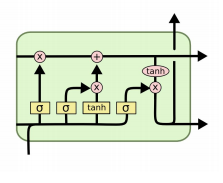

## PPO

Proximal Policy Optimization is a type of Reinforcement Learning algorithm, which directly optimizes the policy network by computing a policy gradient with the help of a critic network. PPO ensures that the updated policy does not stray too far from the original policy.  

## Meta Learning

By using this specific arhitecture, we create two levels of learning. The inner loop in the hidden states of the LSTM where the agent learns about and adapts to the causal model being presented in the episode. And the outer loop as the RL algorithm which drives the meta objective of learning to learn from interactions about the causal structure.

We can few the information phase the the train part and quiz phase as the test part with the training dataset being the meta train and the testing dataset being the meta test.

In [ ]:
class Discrete_LSTM_AC(nn.Module):
    def __init__(self, input_size, n_actions, hidden_size):
        """ LSTM based Actor Critic for discrete action spaces """

        super(Discrete_LSTM_AC, self).__init__()

        self.input_size = input_size
        self.n_actions = n_actions
        self.hidden_size = hidden_size

        self.lstm  = nn.LSTM(input_size, hidden_size).to(torch.double)
        self.fc_pi = nn.Linear(hidden_size, n_actions).to(torch.double)
        self.fc_v  = nn.Linear(hidden_size, 1).to(torch.double)
        self.data = []

    def log_pi(self, x, hidden):
        """ Get log probabilities for each action given an observation and hidden state

        Args:
            x (torch.Tensor): observation
            hidden (torch.Tensor): hidden state to condition on

        Returns: 
            torch.Tensor, torch.Tensor: log probabilities and next hidden state
        """
        x = x.view(-1, 1, self.input_size)
        x, lstm_hidden = self.lstm(x, hidden)
        x = self.fc_pi(x)
        return x, lstm_hidden
    
    def v(self, x, hidden):
        """ Get value for an observation and hidden state

        Args:
            x (torch.Tensor): observation
            hidden (torch.Tensor): hidden state to condition on

        Returns: 
            torch.Tensor: value for state
        """
        x = x.view(-1, 1, self.input_size)
        x, lstm_hidden = self.lstm(x, hidden)
        v = self.fc_v(x)
        return v      

    def init_hidden(self, device=torch.device("cpu"), dtype=torch.double):
        """ Get initial hidden state """
        return (torch.zeros([1, 1, self.hidden_size], device=device, dtype=dtype), torch.zeros([1, 1, self.hidden_size], device=device, dtype=dtype))

    def save(self, path):
        """ Save model to path """
        torch.save(self.state_dict(), path)
    
    def load(self, path):
        """ Load model from path """
        self.load_state_dict(torch.load(path))


def make_batch(data, device=torch.device("cpu"), dtype=torch.double):
    """ Make batch from list of transition 
    
    Adapted from https://github.com/seungeunrho/minimalRL/blob/master/ppo-lstm.py#L48
    """
    s_lst, a_lst, r_lst, s_prime_lst, prob_a_lst, h_in_lst, h_out_lst, done_lst = [], [], [], [], [], [], [], []
    for transition in data:
        s, a, r, s_prime, prob_a, h_in, h_out, done = transition
        
        s_lst.append(s)
        a_lst.append([a])
        r_lst.append([r])
        s_prime_lst.append(s_prime)
        prob_a_lst.append([prob_a])
        h_in_lst.append(h_in)
        h_out_lst.append(h_out)
        done_mask = 0 if done else 1
        done_lst.append([done_mask])
        
    s,a,r,s_prime,done_mask,prob_a = torch.tensor(s_lst), torch.tensor(a_lst), \
                                        torch.tensor(r_lst), torch.tensor(s_prime_lst), \
                                        torch.tensor(done_lst), torch.tensor(prob_a_lst)

    s,a,r,s_prime,done_mask,prob_a = [t.to(device).to(dtype) for t in [s,a,r,s_prime,done_mask,prob_a]]

    return s,a,r,s_prime, done_mask, prob_a, h_in_lst[0], h_out_lst[0]


def ppo(
    env,
    model,
    epochs=10_000,
    episodes_per_epoch=5,
    updates_per_epoch=5,
    lr=3e-4,
    value_loss_weight=0.2,
    entropy_weight_init=0,
    entropy_weight_decay=0,
    gamma=0.9,
    lmbda=0.95,
    eps_clip=0.1,
    max_steps=500,
    log_path=None,
    seed=None,
    verbose=False,
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    dtype=torch.double,
):
    """ Train an Actor Critic model using Proximal Policy Optimization

    References:
        Schulman et. al. Proximal Policy Optimization Algorithms
            (https://arxiv.org/abs/1707.06347)

    Args:
        env (gym.Env): Environment to train model on
        model (torch.nn.Module): Model to train
        epochs (int): Number of epochs to train for. Default: 10_000 
        episodes_per_epoch (int): Number of episodes to sample in each epoch.
            Defaults: 5
        updates_per_epoch (int): Number of updates in each epoch.
            Defaults: 5
        lr (float): Learning rate. Default: 3e-4
        value_loss_weight (float): Weight given to value loss in overall loss.
            Default: 0.2
        entropy_weight_init (float): Initial weight given to entropy in overall 
            loss. Default: 0
        entropy_weight_decay (float): Decay multiplier for entropy weight.
            Default: 0
        gamma (float): Discount factor. Default: 0.9
        lmbda (float): Lambda for GAE. Default: 0.95
        eps_clip (float): Values to clip ratio. Default: 0.1
        max_steps (int): Maximum number of steps in each episode . Default 500.
        log_path (str | None): Path to store logs
            Default: None (don't log) 
        seed (int | None): Seed for RNGs. Default: None (don't seed)
        verbose (bool): Whether to print logs. Default: False
        device (torch.device): Device to train model on. 
            Default: torch.device("cuda" if torch.cuda.is_available() else "cpu")
        dtype (torch.dtype): Data type to tain model in. Default: torch.double
    """

    start_time = datetime.now()

    # get hyperparamaters
    hp = locals()

    # seed
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        env.seed(seed)
        env.action_space.seed(seed)
        env.observation_space.seed(seed)

    # set up logging
    writer = None
    if log_path is not None:
        log_path = Path(log_path).joinpath(f"{start_time:%d%m%y%H%M%S}")
        log_path.joinpath("weights").mkdir(exist_ok=False, parents=True)
        writer = torch.utils.tensorboard.SummaryWriter(log_path)

    # print config
    print(
        f"Start time: {start_time:%d%m%y %H%M%S}\n"
        f"Observation Space: {env.observation_space}\n"
        f"Action Space: {env.action_space}\n"
        f"Model: {model}\n"
        f"Logging to: {log_path}\n"
        f"Hyperparameters: \n{hp}\n"
    )

    # prepare to start train loop
    model.to(device).to(dtype)
    score = 0.0
    steps = 0
    entropy_weight = entropy_weight_init
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        
    for e in range(epochs):

        # collect trajectories
        data = []
        for _ in range(episodes_per_epoch):
            h_out = model.init_hidden(device=device, dtype=dtype)
            s = env.reset()
            rt = 0
            ep_len = 0
            for t in range(max_steps):
                h_in = h_out
                logits, h_out = model.log_pi(torch.tensor(s, device=device, dtype=dtype), h_in)
                logits = logits.view(-1)
                m = torch.distributions.Categorical(logits=logits)
                a = m.sample()
                s_prime, r, done, info = env.step(a.item())
                data.append((s, a, r/100.0, s_prime, m.log_prob(a).item(), h_in, h_out, done))
                s = s_prime
                steps += 1
                ep_len += 1
                rt += r
                if done:
                    break
                    
            score += rt
            
            if writer is not None:
                writer.add_scalar("reward", rt, steps)
                writer.add_scalar("debug/episode_len", ep_len, steps)

        # get batch
        s,a,r,s_prime,done_mask, log_prob_a, (h1_in, h2_in), (h1_out, h2_out) = make_batch(data, device, dtype)
        first_hidden  = (h1_in.detach(), h2_in.detach())
        second_hidden = (h1_out.detach(), h2_out.detach())

        # update weights
        for i in range(updates_per_epoch):
            v_prime = model.v(s_prime, second_hidden).squeeze(1)
            td_target = r + gamma * v_prime * done_mask
            v_s = model.v(s, first_hidden).squeeze(1)
            delta = td_target - v_s
            delta = delta.detach().cpu().numpy()
            
            advantage_lst = []
            advantage = 0.0
            for item in delta[::-1]:
                advantage = gamma * lmbda * advantage + item[0]
                advantage_lst.append([advantage])
            advantage_lst.reverse()
            advantage = torch.tensor(advantage_lst, device=device, dtype=torch.double)

            logits, _ = model.log_pi(s, first_hidden)
            # log_pi_a = log_pi.squeeze(1).gather(1,a)
            curr_dist = torch.distributions.Categorical(logits=logits)
            curr_log_prob_a = curr_dist.log_prob(a)
            ratio = torch.exp(curr_log_prob_a - log_prob_a)
            entropy = torch.mean(curr_dist.entropy())
            approx_kl = torch.mean(log_prob_a - curr_log_prob_a)

            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1-eps_clip, 1+eps_clip) * advantage

            policy_loss = torch.mean(-torch.min(surr1, surr2))
            value_loss = torch.mean(F.smooth_l1_loss(v_s, td_target.detach()))
            loss = policy_loss + value_loss_weight * value_loss - entropy_weight * entropy 

            optimizer.zero_grad()
            loss.backward(retain_graph=True)
            optimizer.step()
        
        # update entropy weight
        entropy_weight *= entropy_weight_decay

        # logging
        if writer is not None:
            writer.add_scalar("loss/policy_loss", policy_loss.item(), steps)
            writer.add_scalar("loss/value_loss", value_loss.item(), steps)
            writer.add_scalar("debug/entropy", entropy.item(), steps)
            writer.add_scalar("debug/approx_kl", approx_kl.item(), steps)

        if verbose and ((e == 0) or ((e+1) % (epochs // 100) == 0)):
            print(
                f"[{(datetime.now()-start_time).seconds} seconds] "
                f"Epoch {e+1}: "
                f"Reward = {(score / ((e+1) * episodes_per_epoch)):.4f}"
            )
            score = 0.0

        # save weights
        if log_path is not None and (e+1) % (epochs // 10) == 0:
            model.save(log_path.joinpath(f"weights/{e+1}.pt"))

    if log_path is not None:
        model.save(log_path.joinpath(f"final_weights.pt"))

    env.close()
    print(f"Finished training in {(datetime.now() - start_time).seconds} seconds")


def test_discrete_ac(
    env, 
    model, 
    episodes, 
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"), 
    dtype=torch.double,
):
    """ Test model on environment for given number of episodes """

    model.to(device).to(dtype)
    rf = 0   

    for _ in range(episodes):
        h = model.init_hidden(device=device, dtype=dtype)
        s = env.reset()
        done = False
        rt = 0

        while not done:
            logits, h = model.log_pi(torch.tensor(s, device=device, dtype=dtype), h)
            s, r, done, info = env.step(torch.distributions.Categorical(logits=logits.view(-1)).sample().item())
            rt += r
            if done:
                break
    
        rf += rt

    env.close()

    return rf/episodes

# Experiments

In [ ]:
results = {}

In [ ]:
exps = {
    "observational": CGMEnv(train_g, action_class="observational"),
    # "conditional": CGMEnv(train_g, action_class="conditional"),
    # "random conditional": CGMEnv(train_g, action_class="random conditional"),
    "interventional": CGMEnv(train_g, action_class="interventional"),
    "random interventional": CGMEnv(train_g, action_class="random interventional"),
    "observational + counterfactual": CGMEnv(train_g, action_class="observational", counterfactual=True),
    # "conditional + counterfactual": CGMEnv(train_g, action_class="conditional", counterfactual=True),
    # "random conditional + counterfactual": CGMEnv(train_g, action_class="random conditional", counterfactual=True),
    "interventional + counterfactual": CGMEnv(train_g, action_class="interventional", counterfactual=True),
    "random interventional + counterfactual": CGMEnv(train_g, action_class="random interventional", counterfactual=True),
}

train_epochs = 10_000
test_episodes = 3000

for exp_name, env in exps.items():
    print(f"Running experiment: {exp_name}")

    model = Discrete_LSTM_AC(input_size=env.observation_space.shape[0], n_actions=env.action_space.n, hidden_size=192)
    wandb.init(project='causal-meta-rl', group=exp_name, entity='atharv', sync_tensorboard=True)
    wandb.watch(model)
    ppo(env, model, epochs=train_epochs, log_path=wandb.run.dir, seed=seed)
    env.reset(graphs=test_g)
    test_score = test_discrete_ac(env, model, episodes=test_episodes)
    wandb.log({"test_score": test_score})
    wandb.finish()

    results[exp_name] = test_score

pd.DataFrame(results.items(), columns=["Experiment", "Test Score"])

Running experiment: observational


wandb: WARNING When using several event log directories, please call wandb.tensorboard.patch(root_logdir="...") before wandb.init


Start time: 020521 210245
Observation Space: Box(inf, inf, (17,), float32)
Action Space: Discrete(8)
Model: Discrete_LSTM_AC(
  (lstm): LSTM(17, 192)
  (fc_pi): Linear(in_features=192, out_features=8, bias=True)
  (fc_v): Linear(in_features=192, out_features=1, bias=True)
)
Logging to: /content/wandb/run-20210502_210243-24k3z0ca/files/020521210245
Hyperparameters: 
{'env': <__main__.CGMEnv object at 0x7f7d60546410>, 'model': Discrete_LSTM_AC(
  (lstm): LSTM(17, 192)
  (fc_pi): Linear(in_features=192, out_features=8, bias=True)
  (fc_v): Linear(in_features=192, out_features=1, bias=True)
), 'epochs': 10000, 'episodes_per_epoch': 5, 'updates_per_epoch': 5, 'lr': 0.0003, 'value_loss_weight': 0.2, 'gamma': 0.9, 'lmbda': 0.95, 'eps_clip': 0.1, 'max_steps': 500, 'log_path': '/content/wandb/run-20210502_210243-24k3z0ca/files', 'seed': 42, 'verbose': False, 'device': device(type='cuda'), 'dtype': torch.float64, 'start_time': datetime.datetime(2021, 5, 2, 21, 2, 45, 704777)}

Finished training 

global_step,249875
_timestamp,1619990046.32488
reward,0.09809
debug/episode_len,5.0
_step,49975
loss/policy_loss,0.04587
loss/value_loss,0.00011
debug/entropy,0.2333
debug/approx_kl,0.00162
test_score,0.53483
_runtime,696


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▂▂▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▇▇▇▇▇▇▇██████
reward,▆▄▆▄▄▆▄▄▃▆▄▆▆▆▄▁▆▆▄▆▄▆▃▅█▅█▅▆▃▆▆▅▆▆▄▃▄▃▅
debug/episode_len,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss/policy_loss,▆█▄▄▄▇▄▆▆▅▅▄▄▆▆▆▅▅▇▇▅▂▆▆▂▅▅▁▃▅▃▆▅▇▆▆▇▆▅▅
loss/value_loss,▂▄▁▂▁▁▂▁▁▁▁▁▁▁▁▂▂▂▁▁▁▂▂▂▂▁▂█▁▁▂▂▁▂▁▁▁▂▁▁
debug/entropy,█▇▆▅▆▅▄▅▅▅▃▄▄▅▆▄▄▃▃▂▃▂▁▂▁▂▃▁▂▃▃▂▂▂▁▂▁▂▂▂
debug/approx_kl,█▆▃▅▅▅▅▅▅▅▄▁█▃▅▄▆▃▄▅▅▅▅▄▃▃▄▄▆▅▃▅▃▅▄▃▃▆▇▁
test_score,▁
_runtime,▁


Running experiment: interventional


wandb: WARNING When using several event log directories, please call wandb.tensorboard.patch(root_logdir="...") before wandb.init


Start time: 020521 211431
Observation Space: Box(inf, inf, (17,), float32)
Action Space: Discrete(8)
Model: Discrete_LSTM_AC(
  (lstm): LSTM(17, 192)
  (fc_pi): Linear(in_features=192, out_features=8, bias=True)
  (fc_v): Linear(in_features=192, out_features=1, bias=True)
)
Logging to: /content/wandb/run-20210502_211429-27l78ylf/files/020521211431
Hyperparameters: 
{'env': <__main__.CGMEnv object at 0x7f7d60546190>, 'model': Discrete_LSTM_AC(
  (lstm): LSTM(17, 192)
  (fc_pi): Linear(in_features=192, out_features=8, bias=True)
  (fc_v): Linear(in_features=192, out_features=1, bias=True)
), 'epochs': 10000, 'episodes_per_epoch': 5, 'updates_per_epoch': 5, 'lr': 0.0003, 'value_loss_weight': 0.2, 'gamma': 0.9, 'lmbda': 0.95, 'eps_clip': 0.1, 'max_steps': 500, 'log_path': '/content/wandb/run-20210502_211429-27l78ylf/files', 'seed': 42, 'verbose': False, 'device': device(type='cuda'), 'dtype': torch.float64, 'start_time': datetime.datetime(2021, 5, 2, 21, 14, 31, 842114)}

Finished training

global_step,249950
_timestamp,1619990735.63875
reward,0.08402
debug/episode_len,5.0
_step,49990
loss/policy_loss,0.03542
loss/value_loss,0.00014
debug/entropy,0.0478
debug/approx_kl,-0.00033
test_score,0.93363
_runtime,679


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇█
reward,▁▂▇▅▅▇▅▅▇▇▅▅▇▅▅▂▇▅▅▇▅▇▅▅█▅█▅▇▄▇▇▅▇▇▅▅▅▄▅
debug/episode_len,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss/policy_loss,▃▄▄▃▆▁▆▅▆▅▅▄▃█▃█▅▅▅▅▅▃▆▅▃▃▃▅▄▇▃▇▅▇▅▅▅▇▆▆
loss/value_loss,▆▅▆▄▂▇▃▂▄▂▁▃▅█▁▄▃▂▁▁▁▂▃▅▂▆▅▇▄▅▃▂▂▂▂▂▁▄▂▁
debug/entropy,█▇▆▄▄▃▃▂▂▂▁▁▁▁▁▁▁▂▂▂▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁
debug/approx_kl,▄▄▃▆▁▃▇▆▅▃▅▄▅▅▄▄▄▅▄▅▄▄▆▅▃▅▄▄▅▇▄█▅▆▅▅▄▄▄▅
test_score,▁
_runtime,▁


Running experiment: random interventional


wandb: WARNING When using several event log directories, please call wandb.tensorboard.patch(root_logdir="...") before wandb.init


Start time: 020521 212600
Observation Space: Box(inf, inf, (17,), float32)
Action Space: Discrete(8)
Model: Discrete_LSTM_AC(
  (lstm): LSTM(17, 192)
  (fc_pi): Linear(in_features=192, out_features=8, bias=True)
  (fc_v): Linear(in_features=192, out_features=1, bias=True)
)
Logging to: /content/wandb/run-20210502_212558-3dopjsk9/files/020521212600
Hyperparameters: 
{'env': <__main__.CGMEnv object at 0x7f7d60546890>, 'model': Discrete_LSTM_AC(
  (lstm): LSTM(17, 192)
  (fc_pi): Linear(in_features=192, out_features=8, bias=True)
  (fc_v): Linear(in_features=192, out_features=1, bias=True)
), 'epochs': 10000, 'episodes_per_epoch': 5, 'updates_per_epoch': 5, 'lr': 0.0003, 'value_loss_weight': 0.2, 'gamma': 0.9, 'lmbda': 0.95, 'eps_clip': 0.1, 'max_steps': 500, 'log_path': '/content/wandb/run-20210502_212558-3dopjsk9/files', 'seed': 42, 'verbose': False, 'device': device(type='cuda'), 'dtype': torch.float64, 'start_time': datetime.datetime(2021, 5, 2, 21, 26, 0, 250947)}

Finished training 

global_step,249995
_timestamp,1619991433.87579
reward,0.04981
debug/episode_len,5.0
_step,49999
loss/policy_loss,-0.01553
loss/value_loss,0.00027
debug/entropy,1.01264
debug/approx_kl,-0.01501
test_score,0.83285
_runtime,688


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▁▂▂▂▂▂▂▂▂▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▇▇▇▇▇▇▇█████
reward,▃██▆▃▃▆▆███▆▆▆█▁▆▆▆▆▆█▆▆█▃▆▆▆▃▆█▆▆▆█▃▆▃▆
debug/episode_len,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss/policy_loss,▂▂▅▃▆▁▄▅▃▆▄▄▅▆▁▄█▃▂▅▆▄▃▆▂▅▆▄▄▄▅▅█▅▃▃▄▄▇▄
loss/value_loss,▇█▄▄▃▇▂▂▄▇▂▂▂▃▅▂█▃▃▅▄▂▄▃▄▁▄▃▃▁▄▃█▃▁▂▃▄▅▂
debug/entropy,█▇▅▄▄▄▃▃▂▂▂▂▃▂▄▃▃▄▅▄▃▃▂▄▄▄▄▄▄▄▄▃▁▃▃▂▁▃▃▃
debug/approx_kl,▅▃▃▄▇▂▃▇▄▁▂▃▄▄▃▃▆▂▂▃▄▄▁▄▃▃▅▃▃▄▅▅▅▄▃▂▃▃█▄
test_score,▁
_runtime,▁


Running experiment: observational + counterfactual


wandb: WARNING When using several event log directories, please call wandb.tensorboard.patch(root_logdir="...") before wandb.init


Start time: 020521 213738
Observation Space: Box(inf, inf, (17,), float32)
Action Space: Discrete(8)
Model: Discrete_LSTM_AC(
  (lstm): LSTM(17, 192)
  (fc_pi): Linear(in_features=192, out_features=8, bias=True)
  (fc_v): Linear(in_features=192, out_features=1, bias=True)
)
Logging to: /content/wandb/run-20210502_213736-3qr02aee/files/020521213738
Hyperparameters: 
{'env': <__main__.CGMEnv object at 0x7f7d60546350>, 'model': Discrete_LSTM_AC(
  (lstm): LSTM(17, 192)
  (fc_pi): Linear(in_features=192, out_features=8, bias=True)
  (fc_v): Linear(in_features=192, out_features=1, bias=True)
), 'epochs': 10000, 'episodes_per_epoch': 5, 'updates_per_epoch': 5, 'lr': 0.0003, 'value_loss_weight': 0.2, 'gamma': 0.9, 'lmbda': 0.95, 'eps_clip': 0.1, 'max_steps': 500, 'log_path': '/content/wandb/run-20210502_213736-3qr02aee/files', 'seed': 42, 'verbose': False, 'device': device(type='cuda'), 'dtype': torch.float64, 'start_time': datetime.datetime(2021, 5, 2, 21, 37, 38, 362145)}

Finished training

global_step,249905
_timestamp,1619992126.13794
reward,-0.05718
debug/episode_len,5.0
_step,49981
loss/policy_loss,0.00757
loss/value_loss,8e-05
debug/entropy,0.52916
debug/approx_kl,0.03759
test_score,0.80643
_runtime,683


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▂▂▂▂▂▂▂▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇████████
reward,█▃▆▆█▆▆▆▆▆▅█▆▆▆▁▆█▆▆▆▃▆██▆▃▆▃▆▆▆███▆▆▆▆█
debug/episode_len,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss/policy_loss,▁▆▂▅▅▄▄▂▅▆▄▄▃▅▆▃▃▆▆▆▅▄▅▇▅▅█▄▆▃▄▅▄▇▃▅▅▇▃▅
loss/value_loss,▂▃▂▄▃▁▁▆▁▃▂▁▂▁▅▂▂▃▃▁▁▂▁▃█▃▃▁▂▂▂▁▃▃▁▂▂▃▁▁
debug/entropy,█▇▅▆▆▆▅▆▅▄▄▅▄▅▃▂▂▂▄▃▃▃▂▄▃▂▂▂▂▁▁▂▂▃▁▂▂▂▂▂
debug/approx_kl,▇▃▂▁▅▃▃▃▄▁▁▃▃▃▄▃▂▃▃▂█▄▃▂▅▅▅▃▄▂▃▄▂▅▄▃▅▄▆▅
test_score,▁
_runtime,▁


Running experiment: interventional + counterfactual


wandb: WARNING When using several event log directories, please call wandb.tensorboard.patch(root_logdir="...") before wandb.init


Start time: 020521 214910
Observation Space: Box(inf, inf, (17,), float32)
Action Space: Discrete(8)
Model: Discrete_LSTM_AC(
  (lstm): LSTM(17, 192)
  (fc_pi): Linear(in_features=192, out_features=8, bias=True)
  (fc_v): Linear(in_features=192, out_features=1, bias=True)
)
Logging to: /content/wandb/run-20210502_214908-1y2gv5d5/files/020521214910
Hyperparameters: 
{'env': <__main__.CGMEnv object at 0x7f7d60660190>, 'model': Discrete_LSTM_AC(
  (lstm): LSTM(17, 192)
  (fc_pi): Linear(in_features=192, out_features=8, bias=True)
  (fc_v): Linear(in_features=192, out_features=1, bias=True)
), 'epochs': 10000, 'episodes_per_epoch': 5, 'updates_per_epoch': 5, 'lr': 0.0003, 'value_loss_weight': 0.2, 'gamma': 0.9, 'lmbda': 0.95, 'eps_clip': 0.1, 'max_steps': 500, 'log_path': '/content/wandb/run-20210502_214908-1y2gv5d5/files', 'seed': 42, 'verbose': False, 'device': device(type='cuda'), 'dtype': torch.float64, 'start_time': datetime.datetime(2021, 5, 2, 21, 49, 10, 867370)}

Finished training

global_step,249955
_timestamp,1619992814.09621
reward,0.12075
debug/episode_len,5.0
_step,49991
loss/policy_loss,-0.05047
loss/value_loss,0.00034
debug/entropy,0.18235
debug/approx_kl,-0.04975
test_score,1.50799
_runtime,678


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▁▁▁▂▂▂▂▂▂▂▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇███
reward,▄▅▄▆▇▅▆▆▁▅▅▆▆▇▆▅▆▇▆▆▆▇▆▇▇▇▆▆█▆▆▇▇▇▇▇▆▆▆▇
debug/episode_len,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss/policy_loss,▁▃▆▅▂▆▁▃▅▃▄▄█▆▃▇▃▃▃▆▄▄▄▅▃▅▄▁▅▄▃▄▄▆▃▄▃▆▂▆
loss/value_loss,▄▃▃▂▂▄▆▃▂▁▁▁▆▃▁█▁▁▂▁▂▁▁▁▁▁▂▂▂▂▁▁▂▂▂▁▁▂▁▁
debug/entropy,█▇▆▆▅▅▃▄▄▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▁▁▂▁▂▁▁▁▁▁▁
debug/approx_kl,▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_score,▁
_runtime,▁


Running experiment: random interventional + counterfactual


wandb: WARNING When using several event log directories, please call wandb.tensorboard.patch(root_logdir="...") before wandb.init


Start time: 020521 220038
Observation Space: Box(inf, inf, (17,), float32)
Action Space: Discrete(8)
Model: Discrete_LSTM_AC(
  (lstm): LSTM(17, 192)
  (fc_pi): Linear(in_features=192, out_features=8, bias=True)
  (fc_v): Linear(in_features=192, out_features=1, bias=True)
)
Logging to: /content/wandb/run-20210502_220035-1ktvzawl/files/020521220038
Hyperparameters: 
{'env': <__main__.CGMEnv object at 0x7f7d60641e90>, 'model': Discrete_LSTM_AC(
  (lstm): LSTM(17, 192)
  (fc_pi): Linear(in_features=192, out_features=8, bias=True)
  (fc_v): Linear(in_features=192, out_features=1, bias=True)
), 'epochs': 10000, 'episodes_per_epoch': 5, 'updates_per_epoch': 5, 'lr': 0.0003, 'value_loss_weight': 0.2, 'gamma': 0.9, 'lmbda': 0.95, 'eps_clip': 0.1, 'max_steps': 500, 'log_path': '/content/wandb/run-20210502_220035-1ktvzawl/files', 'seed': 42, 'verbose': False, 'device': device(type='cuda'), 'dtype': torch.float64, 'start_time': datetime.datetime(2021, 5, 2, 22, 0, 38, 152225)}

Finished training 

global_step,249875
_timestamp,1619993505.30625
reward,0.1183
debug/episode_len,5.0
_step,49975
loss/policy_loss,-0.01159
loss/value_loss,5e-05
debug/entropy,0.34321
debug/approx_kl,0.0123
test_score,0.21907
_runtime,683


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▂▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇██████
reward,▃█▃▆▆▆▆▆▆█▃█▆▆█▁▆█▆▆▆▃▆▆▆▆▆▆█▃▆▆▆█▆▆▆▆█▆
debug/episode_len,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss/policy_loss,▄▅▅▆▂▃▅▅▅▃▆▆▄▇▄▄▅▃▄▄▄▁▅▅▁▄█▄▄▃▄▃▄▆▃▄▃▃▄▃
loss/value_loss,▃▇▃▃▂▂▄█▁▃▄▃▂▃▃▂▂▂▂▂▂▆▂▄▃▁▇▁▃▁▃▁▃▃▂▁▄▃▃▂
debug/entropy,█▇▆▆▆▅▄▄▄▄▄▄▄▃▂▂▃▃▂▂▃▃▂▃▂▂▂▂▁▁▂▃▃▂▁▂▂▁▁▂
debug/approx_kl,█▇▆▅▃▁▆▆▃▆▆▄▅▄▄▇▆▅▄▄▆▆▄▅▄▃▇▅▅▄▅▃▅▅▄▄▄▅▅▄
test_score,▁
_runtime,▁


,Experiment,Test Score
0,observational,0.534833
1,interventional,0.933632
2,random interventional,0.832851
3,observational + counterfactual,0.806432
4,interventional + counterfactual,1.507985
5,random interventional + counterfactual,0.219075


# Results

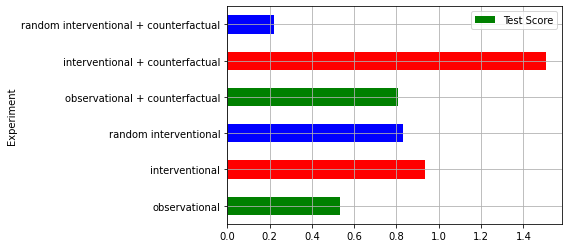

In [ ]:
pd.DataFrame(results.items(), columns=["Experiment", "Test Score"]).plot.barh(x="Experiment", y="Test Score", color=["green", "red", "blue"])
plt.grid()

Coming back to the two main claims that we wanted to test - 

1. Does the agent learn to infer the causal structure for a given problem? From the above results, the agent clearly achieves a positive reward in all setings. Hence we can claim that Meta RL does learn to estimate causal effects.


2. Does the agent learn to usefully interact with the envrionment? In both the interventional and interventional-counterfactual cases, we can see that the active agent performs better than the random agent. This shows that the agent does learn to make useful interactions witht he environment to make causal inferences

We can also see that the agent perfoms better in the interventional settings than the observational one since it receives much more information about the underlying structure by observing results of interventions

## Pearl's Causal Hierarchy

These experiments can be linked to PCH. Our Meta RL alogirthm is sucessfully able to reason about interventions and countefactuals. We could say that the ability to reason about counterfactuals arises from being able learn about the causal structure of the environment during info phase. It needs to be explored whether such ability would hold for more complex environments.

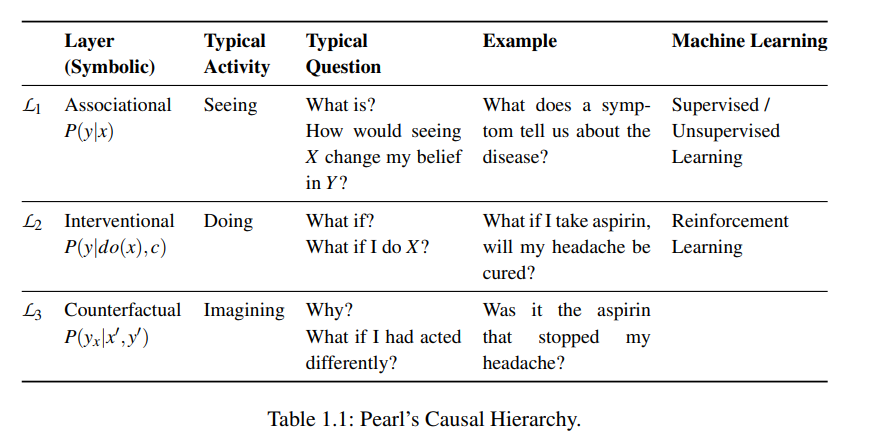

Source: https://causalai.net/r60.pdf



# Ablations

## Size 10 DAGs

Number of total graphs: 10000
Number of equivalence classes of graphs: 10000
Train: 9000 | Test: 1000
Visualisation -


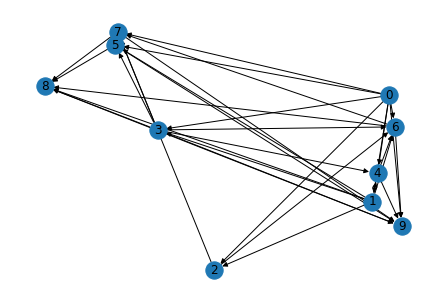

In [ ]:
# download pre made dataset. This can be created from scratch in the cell below

!wget -q http://threewisemonkeys-as.github.io/files/causal-meta-rl/graphs_dataset_n10_10k.pkl
!wget -q http://threewisemonkeys-as.github.io/files/causal-meta-rl/eq_classes_n10_10k.pkl

# # create data (takes ~1 hr on colab)
# data2 = generate_data_randomly(10, 10_000)
# eq_classes2 = partition(data2)

# load data
data2 = pickle.load(open("graphs_dataset_n10_10k.pkl", "rb"))
eq_classes2 = pickle.load(open("eq_classes_n10_10k.pkl", "rb"))

print(f"Number of total graphs: {len(data2)}")
print(f"Number of equivalence classes of graphs: {len(eq_classes2)}")

train_g2, test_g2 = split_train_test(eq_classes2, 1000)
print(f"Train: {len(train_g2)} | Test: {len(test_g2)}")

g2 = data2[0]
print("Visualisation -")
nx.draw(g2, with_labels=True)

In [ ]:
results2 = {}

In [ ]:
exps = {
    "observational (n=10)": {"env": CGMEnv(train_g2, action_class="observational", n=10), "train_epochs": 10_000, "hidden_size": 256, "ewi": 0, "ewd": 0},
    "observational (n=10, info_steps=9)":{"env":  CGMEnv(train_g2, action_class="observational", n=10, info_steps=9), "train_epochs": 10_000, "hidden_size": 256, "ewi": 0, "ewd": 0},
    # "conditional": {"env": CGMEnv(train_g2, action_class="conditional", n=10), "train_epochs": 10_000, "hidden_size": 256, "ewi": 0, "ewd": 0},
    # "random conditional": {"env": CGMEnv(train_g2, action_class="random conditional", n=10), "train_epochs": 10_000, "hidden_size": 256, "ewi": 0, "ewd": 0},
    "interventional (n=10)": {"env": CGMEnv(train_g2, action_class="interventional", n=10), "train_epochs": 15_000, "hidden_size": 256, "ewi": 0, "ewd": 0},
    "interventional (n=10, info_steps=9)": {"env": CGMEnv(train_g2, action_class="interventional", n=10, info_steps=9), "train_epochs": 15_000, "hidden_size": 256, "ewi": 1, "ewd": 0.9995},
    # "random interventional": {"env": CGMEnv(train_g2, action_class="random interventional", n=10), "train_epochs": 10_000, "hidden_size": 256, "ewi": 0, "ewd": 0},
    # "observational + counterfactual": {"env": CGMEnv(train_g2, action_class="observational", counterfactual=True, n=10), "train_epochs": 10_000, "hidden_size": 256, "ewi": 0, "ewd": 0},
    # "conditional + counterfactual": {"env": CGMEnv(train_g2, action_class="conditional", counterfactual=True, n=10), "train_epochs": 10_000, "hidden_size": 256, "ewi": 0, "ewd": 0},
    # "random conditional + counterfactual": {"env": CGMEnv(train_g2, action_class="random conditional", counterfactual=True, n=10), "train_epochs": 10_000, "hidden_size": 256, "ewi": 0, "ewd": 0},
    # "interventional + counterfactual": {"env": CGMEnv(train_g2, action_class="interventional", counterfactual=True, n=10), "train_epochs": 10_000, "hidden_size": 256, "ewi": 0, "ewd": 0},
    # "random interventional + counterfactual": {"env": CGMEnv(train_g2, action_class="random interventional", counterfactual=True, n=10), "train_epochs": 10_000, "hidden_size": 256, "ewi": 0, "ewd": 0},
}

test_episodes = 1000

for exp_name, config in exps.items():
    env = config["env"]
    model = Discrete_LSTM_AC(input_size=env.observation_space.shape[0], n_actions=env.action_space.n, hidden_size=config["hidden_size"])
    wandb.init(project='causal-meta-rl', group=exp_name, entity='atharv', sync_tensorboard=True)
    wandb.watch(model)
    print(f"Running experiment: {exp_name}")
    ppo(env, model, epochs=config["train_epochs"], entropy_weight_init=config["ewi"], entropy_weight_decay=config["ewd"], log_path=wandb.run.dir, seed=seed)
    env.reset(graphs=test_g2)
    test_score = test_discrete_ac(env, model, episodes=test_episodes)
    print(f"Test score: {test_score}")
    wandb.log({"test_score": test_score})
    wandb.finish()
    results2[exp_name] = test_score

pd.DataFrame(results2.items(), columns=["Experiment", "Test Score"])


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Running experiment: observational (n=10)
Start time: 060521 114813
Observation Space: Box(inf, inf, (37,), float32)
Action Space: Discrete(18)
Model: Discrete_LSTM_AC(
  (lstm): LSTM(37, 256)
  (fc_pi): Linear(in_features=256, out_features=18, bias=True)
  (fc_v): Linear(in_features=256, out_features=1, bias=True)
)
Logging to: /content/wandb/run-20210506_114810-3i6ja53q/files/060521114813
Hyperparameters: 
{'env': <__main__.CGMEnv object at 0x7f031e886e90>, 'model': Discrete_LSTM_AC(
  (lstm): LSTM(37, 256)
  (fc_pi): Linear(in_features=256, out_features=18, bias=True)
  (fc_v): Linear(in_features=256, out_features=1, bias=True)
), 'epochs': 10000, 'episodes_per_epoch': 5, 'updates_per_epoch': 5, 'lr': 0.0003, 'value_loss_weight': 0.2, 'entropy_weight_init': 0, 'entropy_weight_decay': 0, 'gamma': 0.9, 'lmbda': 0.95, 'eps_clip': 0.1, 'max_steps': 500, 'log_path': '/content/wandb/run-20210506_114810-3i6ja53q/files', 'seed': 42, 'verbose': False, 'device': device(type='cuda'), 'dtype': t

global_step,249975
_timestamp,1620303544.45145
reward,-0.00647
debug/episode_len,5.0
_step,49995
loss/policy_loss,-0.0852
loss/value_loss,0.00063
debug/entropy,0.5484
debug/approx_kl,-0.05519
test_score,0.72086
_runtime,1872


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▃▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇███
reward,▃▃▃▃▂▅▂▅▃▃▅▅▁▇▃▂▄▄▂▂▃▄▃█▂▄▄▂▂▅▆▂▂▄▃▄▂▄▄▂
debug/episode_len,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss/policy_loss,▆▅▄▆▇█▇▄▂▆▇▇▅▆▇▆▇▇▅▇▁▆▅▅▇▃▇▅▄▅▅▅▇▅▇▇▆▇▅▆
loss/value_loss,▁▁▂▁▁▂▁▂▃▁▂▂▅▁▃▁▂▃▂▁█▁▂▃▁▂▁▂▂▁▃▂▁▂▁▂▃▁▁▁
debug/entropy,█▇▆▆▇▆▆▆▅▆▅▆▆▆▄▅▅▄▄▆▄▄▅▄▃▃▂▁▂▂▁▂▁▂▁▂▂▁▁▁
debug/approx_kl,▂▁▃▄▂▃▂▂▃█▄▃▅▄▄▂▄▂▃▄▂▃▃▂▄▃▅▄▃▃▃▃▄▃▆▅▂▄▃▆
test_score,▁
_runtime,▁


wandb: Currently logged in as: atharv (use `wandb login --relogin` to force relogin)


wandb: WARNING When using several event log directories, please call wandb.tensorboard.patch(root_logdir="...") before wandb.init


Running experiment: observational (n=10, info_steps=9)
Start time: 060521 121936
Observation Space: Box(inf, inf, (37,), float32)
Action Space: Discrete(18)
Model: Discrete_LSTM_AC(
  (lstm): LSTM(37, 256)
  (fc_pi): Linear(in_features=256, out_features=18, bias=True)
  (fc_v): Linear(in_features=256, out_features=1, bias=True)
)
Logging to: /content/wandb/run-20210506_121933-394sybmd/files/060521121936
Hyperparameters: 
{'env': <__main__.CGMEnv object at 0x7f0380db1fd0>, 'model': Discrete_LSTM_AC(
  (lstm): LSTM(37, 256)
  (fc_pi): Linear(in_features=256, out_features=18, bias=True)
  (fc_v): Linear(in_features=256, out_features=1, bias=True)
), 'epochs': 10000, 'episodes_per_epoch': 5, 'updates_per_epoch': 5, 'lr': 0.0003, 'value_loss_weight': 0.2, 'entropy_weight_init': 0, 'entropy_weight_decay': 0, 'gamma': 0.9, 'lmbda': 0.95, 'eps_clip': 0.1, 'max_steps': 500, 'log_path': '/content/wandb/run-20210506_121933-394sybmd/files', 'seed': 42, 'verbose': False, 'device': device(type='cuda

global_step,500000
_timestamp,1620306814.4817
reward,-4.91726
debug/episode_len,10.0
_step,50000
loss/policy_loss,-0.10221
loss/value_loss,0.00606
debug/entropy,2.47095
debug/approx_kl,0.00522
test_score,-1.11101
_runtime,3275


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
reward,▁▂▃▃▃▄▂▃▃▂▃▅▃▃▃▃▃▃▃▁▃▃▅▄▃▃▁▁█▂▃▂▅▃▃▂▁▄▃▁
debug/episode_len,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss/policy_loss,▅▅▅▅▅▅▅▅▅▆▇▆█▄▆▅▅▄▅▅▅▄▆▅▅▅▄▆▆▅▃▁▄▅▅▅▅▆▅▃
loss/value_loss,▁▁▁▁▁▁▁▁▁▁▂▂▃▂▂▁▂▃▁▁▁▁▃▁▁▁▁▁▂▂▄█▃▁▁▂▁▁▁▃
debug/entropy,▆▇▅▅█▇▆▆▇▆▆▂▆██▇▇▆▆▆▆▇▆▅▇▅▆▅█▇▆▅▁▆▄▅▇▂▇▆
debug/approx_kl,▂▇▃▄▃▄▅▃▇█▆▅▇▃▄▅▃▅▅█▄▁▂▆▆▅▄▄▅▁▃▄▅▄▄▅▂▄▆▂
test_score,▁
_runtime,▁


wandb: WARNING When using several event log directories, please call wandb.tensorboard.patch(root_logdir="...") before wandb.init


Running experiment: interventional (n=10)
Start time: 060521 131422
Observation Space: Box(inf, inf, (37,), float32)
Action Space: Discrete(18)
Model: Discrete_LSTM_AC(
  (lstm): LSTM(37, 256)
  (fc_pi): Linear(in_features=256, out_features=18, bias=True)
  (fc_v): Linear(in_features=256, out_features=1, bias=True)
)
Logging to: /content/wandb/run-20210506_131419-17l1e619/files/060521131422
Hyperparameters: 
{'env': <__main__.CGMEnv object at 0x7f031e88ee50>, 'model': Discrete_LSTM_AC(
  (lstm): LSTM(37, 256)
  (fc_pi): Linear(in_features=256, out_features=18, bias=True)
  (fc_v): Linear(in_features=256, out_features=1, bias=True)
), 'epochs': 15000, 'episodes_per_epoch': 5, 'updates_per_epoch': 5, 'lr': 0.0003, 'value_loss_weight': 0.2, 'entropy_weight_init': 0, 'entropy_weight_decay': 0, 'gamma': 0.9, 'lmbda': 0.95, 'eps_clip': 0.1, 'max_steps': 500, 'log_path': '/content/wandb/run-20210506_131419-17l1e619/files', 'seed': 42, 'verbose': False, 'device': device(type='cuda'), 'dtype': 

global_step,374950
_timestamp,1620309383.18777
reward,0.09389
debug/episode_len,5.0
_step,74990
loss/policy_loss,0.02779
loss/value_loss,0.00067
debug/entropy,0.0102
debug/approx_kl,0.00012
test_score,0.38212
_runtime,2539


global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
reward,▃▁▇▅▅▄▄▇▄▆▃▆▆▄▄▄▄▄▄▇▅▆▆▄▄▆▆▇▅▆█▅▇▅▇█▆▇▄▇
debug/episode_len,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss/policy_loss,▃▂▂▃▅▃▃▄▄▄▄▅▅▄▄▄▄▄▅▇▂▂▄█▄▆▇▂▆▅▅▅▄▁▄▁▄▆▂▄
loss/value_loss,▂▃█▂▂▃▃▂▅▁▁▄▁▁▁▁▁▁▁▁▂▂▁▂▂▂▂▃▂▁▁▁▁▁▁▂▁▁▁▁
debug/entropy,█▇▃▄▄▄▂▂▂▂▂▂▂▁▁▁▁▁▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
debug/approx_kl,▁▂▂▂▂▁▁▁▁▁▁▁▁▅▁▄▅█▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_score,▁
_runtime,▁


wandb: WARNING When using several event log directories, please call wandb.tensorboard.patch(root_logdir="...") before wandb.init


Running experiment: interventional (n=10, info_steps=9)
Start time: 060521 135651
Observation Space: Box(inf, inf, (37,), float32)
Action Space: Discrete(18)
Model: Discrete_LSTM_AC(
  (lstm): LSTM(37, 256)
  (fc_pi): Linear(in_features=256, out_features=18, bias=True)
  (fc_v): Linear(in_features=256, out_features=1, bias=True)
)
Logging to: /content/wandb/run-20210506_135648-dwiwv424/files/060521135651
Hyperparameters: 
{'env': <__main__.CGMEnv object at 0x7f031e88e790>, 'model': Discrete_LSTM_AC(
  (lstm): LSTM(37, 256)
  (fc_pi): Linear(in_features=256, out_features=18, bias=True)
  (fc_v): Linear(in_features=256, out_features=1, bias=True)
), 'epochs': 15000, 'episodes_per_epoch': 5, 'updates_per_epoch': 5, 'lr': 0.0003, 'value_loss_weight': 0.2, 'entropy_weight_init': 1, 'entropy_weight_decay': 0.9995, 'gamma': 0.9, 'lmbda': 0.95, 'eps_clip': 0.1, 'max_steps': 500, 'log_path': '/content/wandb/run-20210506_135648-dwiwv424/files', 'seed': 42, 'verbose': False, 'device': device(type

global_step,750000
_timestamp,1620313745.89596
reward,-14.98453
debug/episode_len,10.0
_step,75000
loss/policy_loss,-0.03203
loss/value_loss,0.00043
debug/entropy,1.64768
debug/approx_kl,-0.01059
test_score,-0.25303
_runtime,4364


global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
reward,▂▂▄▃▂▃▃▂▃▁▃▄▂▅▃▄▅▅▇▄▆▅▆▆▄▆█▆▆▅▆▅▆▆▆▆▅▅▅▄
debug/episode_len,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss/policy_loss,▅▅▅▅▁▂▄▆█▅▆▇▄▅▅▆▆▅▆▅▅▅▅▅▆▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
loss/value_loss,▁▁▁▁█▆▆▅█▂▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
debug/entropy,█████▇█▇▇█████▇▇▇▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▁▁▁
debug/approx_kl,▄▄▄▄▁▃▅▃▆▅▄▆▃▃▄▆▆▄▇▃▃▆▆▆█▆▆▂▄▃▅▆▃▃▄▄▃▆▃▆
test_score,▁
_runtime,▁


,Experiment,Test Score
0,observational (n=10),0.720861
1,"observational (n=10, info_steps=9)",-1.111012
2,interventional (n=10),0.382124
3,"interventional (n=10, info_steps=9)",-0.253034


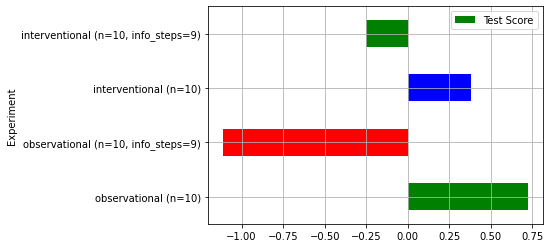

In [ ]:
pd.DataFrame(results2.items(), columns=["Experiment", "Test Score"]).plot.barh(x="Experiment", y="Test Score", color=["green", "red", "blue"])
plt.grid()

Note that the performance of the agent trained on environment with `n_steps=9` is temperamental. A previous run resulted in agent getting consistent positive rewards - 


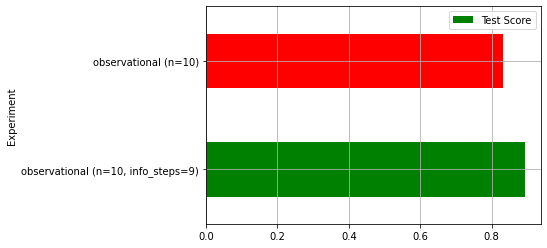

All runs can be found at - https://wandb.ai/atharv/causal-meta-rl

## `var=0.5`

In [ ]:
results = {}
exps = {
    "observational (var=0.5)": CGMEnv(train_g, action_class="observational", var=0.5),
    "interventional (var=0.5)": CGMEnv(train_g, action_class="interventional", var=0.5),
    "interventional + counterfactual (var=0.5)": CGMEnv(train_g, action_class="interventional", counterfactual=True, var=0.5),
}

train_epochs = 10_000
test_episodes = 3000

for exp_name, env in exps.items():

    model = Discrete_LSTM_AC(input_size=env.observation_space.shape[0], n_actions=env.action_space.n, hidden_size=192)
    wandb.init(project='causal-meta-rl', group=exp_name, entity='atharv', sync_tensorboard=True)
    wandb.watch(model)
    print(f"Running experiment: {exp_name}")
    ppo(env, model, epochs=train_epochs, log_path=wandb.run.dir, seed=seed)
    env.reset(graphs=test_g)
    test_score = test_discrete_ac(env, model, episodes=test_episodes)
    wandb.log({"test_score": test_score})
    wandb.finish()

    results[exp_name] = test_score

print(pd.DataFrame(results.items(), columns=["Experiment", "Test Score"]))
pd.DataFrame(results.items(), columns=["Experiment", "Test Score"]).plot.barh(x="Experiment", y="Test Score", color=["green", "red", "blue"])
plt.grid()

global_step,3135
_timestamp,1620374279.13445
reward,-10.0
debug/episode_len,5.0
_step,626
loss/policy_loss,0.01456
loss/value_loss,0.00097
debug/entropy,2.00539
debug/approx_kl,0.02269


global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward,▁▅▄▄▁▃▁▄▁▁▃▃▃▁▁▁▄▁▃▄▁█▁▁▁▃▁▁▁▄▅▁█▁▄▁▁▆▁▁
debug/episode_len,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss/policy_loss,█▇▅▄▄▆▄▁▇▃▄▄▅▃▅▄▃▄▄▂▃▃▆▃▄▄▃▆▃▄▃▂▁▄▁▇▃▃▃▄
loss/value_loss,█▅▂▂▁▆▂▄▄▁▁▁▂▄▃▂▂▂▁▆▃▆▅▂▁▄▂▄▃▆▂▂▃▄▇▇▃▃▅▄
debug/entropy,██████▇▇▇▇▇▆▇▆▆▆▆▆▆▇▆▅▆▇▇▆▃▅▅▆▅▃▂▅▂▃▅▂▁▂
debug/approx_kl,▄▄▃▄▄▄▄▁▃▅▁▄▄▄▆▄▄▁▄▅▂▅▃▄▄▄█▅▅▄▄▃▁▄▅▅▃▄▅▁


wandb: WARNING When using several event log directories, please call wandb.tensorboard.patch(root_logdir="...") before wandb.init


Running experiment: observational (var=0.5)
Start time: 070521 075833
Observation Space: Box(inf, inf, (17,), float32)
Action Space: Discrete(8)
Model: Discrete_LSTM_AC(
  (lstm): LSTM(17, 192)
  (fc_pi): Linear(in_features=192, out_features=8, bias=True)
  (fc_v): Linear(in_features=192, out_features=1, bias=True)
)
Logging to: /content/wandb/run-20210507_075820-2cth9046/files/070521075833
Hyperparameters: 
{'env': <__main__.CGMEnv object at 0x7f8495288ed0>, 'model': Discrete_LSTM_AC(
  (lstm): LSTM(17, 192)
  (fc_pi): Linear(in_features=192, out_features=8, bias=True)
  (fc_v): Linear(in_features=192, out_features=1, bias=True)
), 'epochs': 10000, 'episodes_per_epoch': 5, 'updates_per_epoch': 5, 'lr': 0.0003, 'value_loss_weight': 0.2, 'entropy_weight_init': 0, 'entropy_weight_decay': 0, 'gamma': 0.9, 'lmbda': 0.95, 'eps_clip': 0.1, 'max_steps': 500, 'log_path': '/content/wandb/run-20210507_075820-2cth9046/files', 'seed': 42, 'verbose': False, 'device': device(type='cuda'), 'dtype': t

global_step,249960
_timestamp,1620375484.3768
reward,0.57291
debug/episode_len,5.0
_step,49992
loss/policy_loss,-0.02771
loss/value_loss,0.00025
debug/entropy,0.54217
debug/approx_kl,-0.00613
test_score,1.0306
_runtime,1193


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇█████
reward,█▆▆▅▄▅▄▃▆▄▆▅▆▃▄▁▃▆▄▄▄▃▄▄▄▄▆▄▄▆▆▁▅▅▄▆▅▄▄▄
debug/episode_len,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss/policy_loss,▃█▆█▅▆▇▅▃▂▂▄▂▅█▄█▅▆▆▆▅▅▄▅▁▆▄▅▅▆▇▅▃▆█▄▆▇▂
loss/value_loss,▆▅▃█▂▁▂▂▃▂▂▃▂▃▄▁▃▁▁▂▂▂▃▁▁▄▃▂▁▃▄▃▂▁▂▁▂▁▃▃
debug/entropy,█▇▅▄▅▄▄▄▄▃▄▃▄▃▃▃▃▃▄▂▃▃▃▃▁▃▃▂▂▄▂▂▁▂▃▂▂▂▂▁
debug/approx_kl,▆▄▅▄▄▃▆▃▄▂▄▅▅▆▇▆▄▂█▅▆▆▃▃▁▄▄▃▄▂▅▃▂▄▄▄▅▇▅▃
test_score,▁
_runtime,▁


wandb: WARNING When using several event log directories, please call wandb.tensorboard.patch(root_logdir="...") before wandb.init


Running experiment: interventional (var=0.5)
Start time: 070521 081835
Observation Space: Box(inf, inf, (17,), float32)
Action Space: Discrete(8)
Model: Discrete_LSTM_AC(
  (lstm): LSTM(17, 192)
  (fc_pi): Linear(in_features=192, out_features=8, bias=True)
  (fc_v): Linear(in_features=192, out_features=1, bias=True)
)
Logging to: /content/wandb/run-20210507_081832-3g0gg3an/files/070521081835
Hyperparameters: 
{'env': <__main__.CGMEnv object at 0x7f8495288fd0>, 'model': Discrete_LSTM_AC(
  (lstm): LSTM(17, 192)
  (fc_pi): Linear(in_features=192, out_features=8, bias=True)
  (fc_v): Linear(in_features=192, out_features=1, bias=True)
), 'epochs': 10000, 'episodes_per_epoch': 5, 'updates_per_epoch': 5, 'lr': 0.0003, 'value_loss_weight': 0.2, 'entropy_weight_init': 0, 'entropy_weight_decay': 0, 'gamma': 0.9, 'lmbda': 0.95, 'eps_clip': 0.1, 'max_steps': 500, 'log_path': '/content/wandb/run-20210507_081832-3g0gg3an/files', 'seed': 42, 'verbose': False, 'device': device(type='cuda'), 'dtype': 

global_step,249905
_timestamp,1620376686.27405
reward,9.98682
debug/episode_len,5.0
_step,49981
loss/policy_loss,-0.00678
loss/value_loss,0.00073
debug/entropy,0.45656
debug/approx_kl,-0.00786
test_score,1.08739
_runtime,1192


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇██
reward,▁▂▄▅▅▄▅▅▅▅█▆▅▆▅▂▅▄▆▅▅▄▅▅▅▆▇▅▅▆▆▇▅▅▅█▅▅▅▅
debug/episode_len,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss/policy_loss,▆▄▄▄▅▇▆▄█▇▄▆▅▃▆▆█▆▅▇▅▅▄▅▆▄▁▆█▃▇▆▂▂▆▇▅▄▇▅
loss/value_loss,▂▂▃▁▂▁▃▁█▁▁▁▁▁▁▂▃▁▁▂▃▁▁▁▃▁▃▂▂▁▁▁▂▂▁▁▁▁▁▁
debug/entropy,█▇▆▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▂▂▁▁▁▁▁▂▁▁▂▁▂▂▂▂▂▃▃▂▂
debug/approx_kl,▄▁█▆▅▃█▄▄▅▄▃▆▃▅▂▄▃▄▅▆▄▄▄▄▃▂▄▃▁▄▆▅▃▄▄▄▄▅▃
test_score,▁
_runtime,▁


wandb: WARNING When using several event log directories, please call wandb.tensorboard.patch(root_logdir="...") before wandb.init


Running experiment: interventional + counterfactual (var=0.5)
Start time: 070521 083837
Observation Space: Box(inf, inf, (17,), float32)
Action Space: Discrete(8)
Model: Discrete_LSTM_AC(
  (lstm): LSTM(17, 192)
  (fc_pi): Linear(in_features=192, out_features=8, bias=True)
  (fc_v): Linear(in_features=192, out_features=1, bias=True)
)
Logging to: /content/wandb/run-20210507_083834-3uxrbizc/files/070521083837
Hyperparameters: 
{'env': <__main__.CGMEnv object at 0x7f8497c3efd0>, 'model': Discrete_LSTM_AC(
  (lstm): LSTM(17, 192)
  (fc_pi): Linear(in_features=192, out_features=8, bias=True)
  (fc_v): Linear(in_features=192, out_features=1, bias=True)
), 'epochs': 10000, 'episodes_per_epoch': 5, 'updates_per_epoch': 5, 'lr': 0.0003, 'value_loss_weight': 0.2, 'entropy_weight_init': 0, 'entropy_weight_decay': 0, 'gamma': 0.9, 'lmbda': 0.95, 'eps_clip': 0.1, 'max_steps': 500, 'log_path': '/content/wandb/run-20210507_083834-3uxrbizc/files', 'seed': 42, 'verbose': False, 'device': device(type='

global_step,249990
_timestamp,1620377863.33784
reward,0.27847
debug/episode_len,5.0
_step,49998
loss/policy_loss,0.01303
loss/value_loss,0.0004
debug/entropy,0.01453
debug/approx_kl,0.00028
test_score,1.04454
_runtime,1167


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇███
reward,▂▂▁▇▇▄▇▄▄▅▄▅▄▅▇▂▅▆▇▅▇▅▄▇▅▇▅█▅▇▇▇▅▇▇▅▇▅▇▇
debug/episode_len,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss/policy_loss,▆▃▂▅▁▅▆▆▅▇▇▃▆▄▅▄▅▃▅▅▅▅▃█▆▇▅▂▇▅▆▇█▄▂▆▃▅█▄
loss/value_loss,▂▂█▁▂▂▁▂▂▂▁▂▂▂▁▃▁▁▁▁▁▁▁▂▁▂▁▃▂▁▁▁▂▁▄▂▂▁▁▁
debug/entropy,█▇▆▄▄▅▄▅▄▄▅▄▄▃▂▂▂▂▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
debug/approx_kl,▃▂█▄▂▆▃▅▇▂█▃▄▃▄▃▂▂▃▄▃▃▁▄▄▃▂▂▂▂▄▃▂▃▃▃▃▃▄▃
test_score,▁
_runtime,▁


                                  Experiment  Test Score
0                    observational (var=0.5)    1.030599
1                   interventional (var=0.5)    1.087387
2  interventional + counterfactual (var=0.5)    1.044540


NameError: ignored

## `mu=5` `info_intervention=0` `quiz_intervention=10`

wandb: WARNING When using several event log directories, please call wandb.tensorboard.patch(root_logdir="...") before wandb.init


Running experiment: observational (var=0.5)
Start time: 070521 093958
Observation Space: Box(inf, inf, (17,), float32)
Action Space: Discrete(8)
Model: Discrete_LSTM_AC(
  (lstm): LSTM(17, 192)
  (fc_pi): Linear(in_features=192, out_features=8, bias=True)
  (fc_v): Linear(in_features=192, out_features=1, bias=True)
)
Logging to: /content/wandb/run-20210507_093955-36mzz4rt/files/070521093958
Hyperparameters: 
{'env': <__main__.CGMEnv object at 0x7f84937eb110>, 'model': Discrete_LSTM_AC(
  (lstm): LSTM(17, 192)
  (fc_pi): Linear(in_features=192, out_features=8, bias=True)
  (fc_v): Linear(in_features=192, out_features=1, bias=True)
), 'epochs': 10000, 'episodes_per_epoch': 5, 'updates_per_epoch': 5, 'lr': 0.0003, 'value_loss_weight': 0.2, 'entropy_weight_init': 0, 'entropy_weight_decay': 0, 'gamma': 0.9, 'lmbda': 0.95, 'eps_clip': 0.1, 'max_steps': 500, 'log_path': '/content/wandb/run-20210507_093955-36mzz4rt/files', 'seed': 42, 'verbose': False, 'device': device(type='cuda'), 'dtype': t

global_step,249960
_timestamp,1620381568.60435
reward,10.0
debug/episode_len,5.0
_step,49992
loss/policy_loss,0.01032
loss/value_loss,0.00015
debug/entropy,0.53428
debug/approx_kl,0.14456
test_score,9.29039
_runtime,1192


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇██
reward,▁▂▁▇▄▇▅▇▅▇▇▅▂▇▇▁▇▇▇▇▇▅▇▇▇▅▄▇▇█▅▇▄▇▇▅█▇▇▇
debug/episode_len,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss/policy_loss,▄▃▂▅▅▄▄▇▄▇▅▂▇█▄▅▆█▂▄▄▆▄▅▂▁▅▄▅▇▆▅▅▅▃▂█▃▄▄
loss/value_loss,▃█▆▁▂▂▂▅▃▂▂▄▃▃▄▁▁▃▄▃▂▃▁▂▃▂▁▂▂▄▂▂▂▁▁▁▅▁▂▁
debug/entropy,█▇▃▃▃▄▃▃▂▃▃▂▃▄▃▁▃▃▃▃▅▂▁▁▁▂▃▂▁▂▁▂▂▂▂▂▂▁▂▃
debug/approx_kl,▄▃█▅▄▅▃▄▄▄▁▅▅▆▆▄▃█▂▄▄▆▃▆▃▃▅▄▃▆▄▄▅▃▃▅▅▃▄▂
test_score,▁
_runtime,▁


wandb: WARNING When using several event log directories, please call wandb.tensorboard.patch(root_logdir="...") before wandb.init


Running experiment: interventional (var=0.5)
Start time: 070521 100000
Observation Space: Box(inf, inf, (17,), float32)
Action Space: Discrete(8)
Model: Discrete_LSTM_AC(
  (lstm): LSTM(17, 192)
  (fc_pi): Linear(in_features=192, out_features=8, bias=True)
  (fc_v): Linear(in_features=192, out_features=1, bias=True)
)
Logging to: /content/wandb/run-20210507_095957-2iven3k6/files/070521100000
Hyperparameters: 
{'env': <__main__.CGMEnv object at 0x7f84937eb810>, 'model': Discrete_LSTM_AC(
  (lstm): LSTM(17, 192)
  (fc_pi): Linear(in_features=192, out_features=8, bias=True)
  (fc_v): Linear(in_features=192, out_features=1, bias=True)
), 'epochs': 10000, 'episodes_per_epoch': 5, 'updates_per_epoch': 5, 'lr': 0.0003, 'value_loss_weight': 0.2, 'entropy_weight_init': 0, 'entropy_weight_decay': 0, 'gamma': 0.9, 'lmbda': 0.95, 'eps_clip': 0.1, 'max_steps': 500, 'log_path': '/content/wandb/run-20210507_095957-2iven3k6/files', 'seed': 42, 'verbose': False, 'device': device(type='cuda'), 'dtype': 

global_step,250000
_timestamp,1620382744.92441
reward,20.21675
debug/episode_len,5.0
_step,50000
loss/policy_loss,0.02792
loss/value_loss,0.00022
debug/entropy,0.42644
debug/approx_kl,0.005
test_score,8.45713
_runtime,1165


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▂▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇███
reward,▇▃▁▃▅▅▆▅▄▇▂▆▄▂▆▃▇█▇▇▇▆▇▇▇▃▆▇▇█▄▇▇▇▇▆█▇▇▇
debug/episode_len,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss/policy_loss,▂▅▄▃▄▄▄▆▆▆▆▃▇█▁▃▅▅▂▃▃▁▃▄▂▃▃▄▄▇▅▄▅▅▃▂▄▄▃▄
loss/value_loss,▆▄▃▃▃▃█▄▆▅▇▂██▅▂▁▂▅▄▂▅▂▃▂▂▃▂▁█▂▄▂▁▁▁▁▁▂▄
debug/entropy,█▇▆▆▆▅▅▃▃▂▃▃▃▂▂▂▃▃▂▂▂▃▂▂▂▃▃▃▃▄▃▃▂▂▃▂▂▁▂▂
debug/approx_kl,▁▁▂▅▃▂▂▂▅▂▂▂█▆▂▂▂▃▂▃▂▂▁▃▃▂▂▂▂▆▄▃▂▃▂▂▃▂▂▆
test_score,▁
_runtime,▁


wandb: WARNING When using several event log directories, please call wandb.tensorboard.patch(root_logdir="...") before wandb.init


Running experiment: interventional + counterfactual (var=0.5)
Start time: 070521 101935
Observation Space: Box(inf, inf, (17,), float32)
Action Space: Discrete(8)
Model: Discrete_LSTM_AC(
  (lstm): LSTM(17, 192)
  (fc_pi): Linear(in_features=192, out_features=8, bias=True)
  (fc_v): Linear(in_features=192, out_features=1, bias=True)
)
Logging to: /content/wandb/run-20210507_101933-2tmh7o8a/files/070521101935
Hyperparameters: 
{'env': <__main__.CGMEnv object at 0x7f84937ebc90>, 'model': Discrete_LSTM_AC(
  (lstm): LSTM(17, 192)
  (fc_pi): Linear(in_features=192, out_features=8, bias=True)
  (fc_v): Linear(in_features=192, out_features=1, bias=True)
), 'epochs': 10000, 'episodes_per_epoch': 5, 'updates_per_epoch': 5, 'lr': 0.0003, 'value_loss_weight': 0.2, 'entropy_weight_init': 0, 'entropy_weight_decay': 0, 'gamma': 0.9, 'lmbda': 0.95, 'eps_clip': 0.1, 'max_steps': 500, 'log_path': '/content/wandb/run-20210507_101933-2tmh7o8a/files', 'seed': 42, 'verbose': False, 'device': device(type='

global_step,249985
_timestamp,1620383916.59349
reward,10.0
debug/episode_len,5.0
_step,49997
loss/policy_loss,0.00525
loss/value_loss,0.00057
debug/entropy,0.24355
debug/approx_kl,0.00178
test_score,8.9484
_runtime,1161


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇████
reward,▃▃▃▃▃▅▆▆▆▆▁▆█▆▆▃▆▆▆▆▆▆▂▃▆▆▆▇▆▆▆▆▆▆▆▆▆▆▄▆
debug/episode_len,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss/policy_loss,▄▃▆▆▆▁▅▆▅▄█▇▄▆▄▅▅▆▆▄▅▅▇▅▄▇▇▄▇▅▇▅▆▄▆▆▅▆▆▇
loss/value_loss,▄▃▄▅▅▆▇▃▂▄▇▅█▁▃▆▂▂▄▄▃▃▅▁▃▁▂▆▁▂▃▁▂▁▁▂▂▁▂▄
debug/entropy,█▇▆▆▅▄▃▂▂▂▃▂▃▂▂▂▂▃▂▃▂▁▁▁▁▁▁▂▁▂▁▂▂▂▁▃▂▁▂▂
debug/approx_kl,▂▂▃█▃▃▂▂▃▃▆▄▃▃▁▅▂▆▄▃▃▃▄▃▃▂▅▂▃▂▄▃▇▃▄▆▃▄▆▂
test_score,▁
_runtime,▁


                                  Experiment  Test Score
0                    observational (var=0.5)    9.290391
1                   interventional (var=0.5)    8.457129
2  interventional + counterfactual (var=0.5)    8.948398


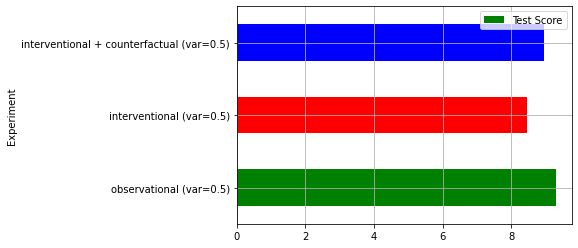

In [ ]:
results = {}
exps = {
    "observational (var=0.5)": CGMEnv(train_g, action_class="observational", mu=5, info_intervention=0, quiz_intervention=10),
    "interventional (var=0.5)": CGMEnv(train_g, action_class="interventional", mu=5, info_intervention=0, quiz_intervention=10),
    "interventional + counterfactual (var=0.5)": CGMEnv(train_g, action_class="interventional", counterfactual=True, mu=5, info_intervention=0, quiz_intervention=10),
}

train_epochs = 10_000
test_episodes = 3000

for exp_name, env in exps.items():

    model = Discrete_LSTM_AC(input_size=env.observation_space.shape[0], n_actions=env.action_space.n, hidden_size=192)
    wandb.init(project='causal-meta-rl', group=exp_name, entity='atharv', sync_tensorboard=True)
    wandb.watch(model)
    print(f"Running experiment: {exp_name}")
    ppo(env, model, epochs=train_epochs, log_path=wandb.run.dir, seed=seed)
    env.reset(graphs=test_g)
    test_score = test_discrete_ac(env, model, episodes=test_episodes)
    wandb.log({"test_score": test_score})
    wandb.finish()

    results[exp_name] = test_score

print(pd.DataFrame(results.items(), columns=["Experiment", "Test Score"]))
pd.DataFrame(results.items(), columns=["Experiment", "Test Score"]).plot.barh(x="Experiment", y="Test Score", color=["green", "red", "blue"])
plt.grid()